In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

### Loading file generated from previous step

In [3]:
# Definition of paths
data_dir = os.path.join(os.getcwd(), '../Dataset')

preprocessed_out_dir = os.path.join(data_dir, 'Preprocessed')
os.makedirs(preprocessed_out_dir, exist_ok=True)

preprocessed_saved_filepath = os.path.join(preprocessed_out_dir, 'preprocessed.pkl')

df = pd.read_pickle(preprocessed_saved_filepath)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 69987 entries, 0 to 101765
Data columns (total 44 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   encounter_id              69987 non-null  int64   
 1   patient_nbr               69987 non-null  int64   
 2   race                      69987 non-null  category
 3   gender                    69987 non-null  object  
 4   age                       69987 non-null  object  
 5   admission_type_id         69987 non-null  category
 6   discharge_disposition_id  69987 non-null  category
 7   admission_source_id       69987 non-null  category
 8   time_in_hospital          69987 non-null  int64   
 9   medical_specialty         69987 non-null  category
 10  num_lab_procedures        69987 non-null  int64   
 11  num_procedures            69987 non-null  int64   
 12  num_medications           69987 non-null  int64   
 13  number_outpatient         69987 non-null  int64   

In [5]:
df.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,...,max_glu_serum_measured,A1Cresult_measured,repaglinide_measured,glimepiride_measured,rosiglitazone_measured,pioglitazone_measured,glyburide_measured,glipizide_measured,metformin_measured,insulin_measured
0,2278392,8222157,Caucasian,Female,[0-10),6,25,1,1,Pediatrics-Endocrinology,...,No,No,No,No,No,No,No,No,No,No
1,149190,55629189,Caucasian,Female,[10-20),1,1,7,3,Unknown,...,No,No,No,No,No,No,No,No,No,Yes
2,64410,86047875,AfricanAmerican,Female,[20-30),1,1,7,2,Unknown,...,No,No,No,No,No,No,No,Yes,No,No
3,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,Unknown,...,No,No,No,No,No,No,No,No,No,Yes
4,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,Unknown,...,No,No,No,No,No,No,No,Yes,No,Yes


In [6]:
#encoding age to numberical category
age_categories = [
    '[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)', '[50-60)',
    '[60-70)', '[70-80)', '[80-90)', '[90-100)'
]
age_mapping = {category: i for i, category in enumerate(age_categories)}
df['age_encoded'] = df['age'].map(age_mapping)

### Prepare the data for training

In [7]:
y = df['readmitted']
X = df[['age_encoded', 'num_procedures', 'num_medications', 'number_outpatient', 'number_inpatient', 'number_inpatient', 'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'time_in_hospital', 'number_emergency']]
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size = 0.8,
                                                    stratify = y,
                                                    random_state = 123) 

In [8]:
print(X_train.shape)
print(X_test.shape)

(55989, 11)
(13998, 11)


### Train and Evaluate the model

In [9]:

classifier = LogisticRegression()
model = classifier.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [10]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
confusion_matrix(y_test, model.predict(X_test))

Accuracy: 0.6164452064580654


array([[7549,  747],
       [4622, 1080]])

There is too many false positives, planning to increase the threshold. This will make the model more conservative about predicting a positive class, thereby reducing false positives at the cost of possibly increasing false negatives.

In [11]:
# Get predicted probabilities
probs = model.predict_proba(X_test)[:, 1]

# Adjust the threshold to 0.40 (instead of 0.5)
threshold = 0.30
y_pred = (probs >= threshold).astype(int)
y_pred_label = ['YES' if pred == 1 else 'NO' for pred in y_pred]

# Evaluate
print(confusion_matrix(y_test, y_pred_label).ravel())
print(classification_report(y_test, y_pred_label))


[1066 7230  348 5354]


              precision    recall  f1-score   support

          NO       0.75      0.13      0.22      8296
         YES       0.43      0.94      0.59      5702

    accuracy                           0.46     13998
   macro avg       0.59      0.53      0.40     13998
weighted avg       0.62      0.46      0.37     13998



In [12]:
# Get predicted probabilities
probs = model.predict_proba(X_test)[:, 1]

# Adjust the threshold to 0.30 (instead of 0.5)
threshold = 0.30
y_pred = (probs >= threshold).astype(int)
y_pred_label = ['YES' if pred == 1 else 'NO' for pred in y_pred]

# Evaluate
print(confusion_matrix(y_test, y_pred_label).ravel())
print(classification_report(y_test, y_pred_label))


[1066 7230  348 5354]


              precision    recall  f1-score   support

          NO       0.75      0.13      0.22      8296
         YES       0.43      0.94      0.59      5702

    accuracy                           0.46     13998
   macro avg       0.59      0.53      0.40     13998
weighted avg       0.62      0.46      0.37     13998



Threshold will tell if the probablity of outcome is greated thant this value we can categorize it into the YES bucket. By reducing the threashold we can increase the number of YES predictions rightly but also will do more number of wrong NO predections that will reduce the accuracy.

### Hyper parameter tuning

In [13]:
# Define Logistic Regression model
log_reg = LogisticRegression(max_iter=1000)

# Define the hyperparameter grid
param_grid = {
    'C': np.logspace(-4, 4, 20),         # Regularization strength
    'penalty': ['l1', 'l2'],             # Regularization type
    'solver': ['liblinear', 'saga'], # Solvers
    'max_iter': [100, 200, 300],         # Max iterations
    'tol': [1e-4, 1e-3, 1e-2]            # Tolerance for convergence
}

# Set up GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best hyperparameters found: ", grid_search.best_params_)

Fitting 5 folds for each of 720 candidates, totalling 3600 fits


Best hyperparameters found:  {'C': np.float64(0.004832930238571752), 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.001}


In [14]:
# Get the best model
best_log_reg = grid_search.best_estimator_

# Evaluate the model on the test set
y_pred = best_log_reg.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          NO       0.62      0.92      0.74      8296
         YES       0.60      0.18      0.28      5702

    accuracy                           0.62     13998
   macro avg       0.61      0.55      0.51     13998
weighted avg       0.61      0.62      0.55     13998



Feature engineering

In [15]:
columns = ['age_encoded', 'num_procedures', 'num_medications', 'number_outpatient', 'number_inpatient', 'number_inpatient', 'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'time_in_hospital', 'number_emergency']

for column in columns:
    bivariate_percentage = df.groupby(column)['readmitted'].value_counts(normalize=True).unstack() * 100
    # Optionally, fill NaN with 0 if needed
    bivariate_percentage = bivariate_percentage.fillna(0)
    print(bivariate_percentage)

readmitted          NO        YES
age_encoded                      
0            82.352941  17.647059
1            68.539326  31.460674
2            67.885816  32.114184
3            67.421991  32.578009
4            64.132982  35.867018
5            62.642701  37.357299
6            59.440337  40.559663
7            55.236915  44.763085
8            54.446445  45.553555
9            63.259512  36.740488
readmitted             NO        YES
num_procedures                      
0               57.595409  42.404591
1               59.948560  40.051440
2               60.883669  39.116331
3               61.318337  38.681663
4               59.473151  40.526849
5               60.109290  39.890710
6               61.924577  38.075423
readmitted               NO         YES
num_medications                        
1                 72.222222   27.777778
2                 72.634271   27.365729
3                 72.457627   27.542373
4                 68.760908   31.239092
5                 6

The class distribution for each value of num_procedures and max_glu_serum is almost similar, these column wont have much impact on final model

In [16]:
#bivariate analysis as a percentage of final outcome
medicine_columns = ['metformin', 'repaglinide', 'glimepiride',
                    'glipizide', 'glyburide', 'pioglitazone',
                    'rosiglitazone', 'insulin',]
for column in medicine_columns:
    bivariate_percentage = df.groupby(column)['readmitted'].value_counts(normalize=True).unstack() * 100
    # Optionally, fill NaN with 0 if needed
    bivariate_percentage = bivariate_percentage.fillna(0)
    print(bivariate_percentage)

readmitted         NO        YES
metformin                       
-1          60.689655  39.310345
 0          58.655120  41.344880
 1          61.437477  38.562523
 2          63.069544  36.930456
readmitted          NO        YES
repaglinide                      
-1           57.142857  42.857143
 0           59.378891  40.621109
 1           49.755501  50.244499
 2           56.338028  43.661972
readmitted          NO        YES
glimepiride                      
-1           54.411765  45.588235
 0           59.302448  40.697552
 1           58.523409  41.476591
 2           61.304348  38.695652
readmitted         NO        YES
glipizide                       
-1          50.134771  49.865229
 0          59.772377  40.227623
 1          56.119033  43.880967
 2          55.148342  44.851658
readmitted         NO        YES
glyburide                       
-1          54.066986  45.933014
 0          59.401071  40.598929
 1          58.428466  41.571534
 2          57.911909  42.08809

In [17]:
y = df['readmitted']
X = df[['age_encoded', 'num_medications', 'number_outpatient', 'number_inpatient', 'number_inpatient', 'number_diagnoses', 'A1Cresult', 'time_in_hospital', 'number_emergency']]
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size = 0.8,
                                                    stratify = y,
                                                    random_state = 123) 
classifier = LogisticRegression()
model = classifier.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

          NO       0.62      0.92      0.74      8296
         YES       0.60      0.18      0.28      5702

    accuracy                           0.62     13998
   macro avg       0.61      0.55      0.51     13998
weighted avg       0.61      0.62      0.55     13998



In [18]:
# Get predicted probabilities
probs = model.predict_proba(X_test)[:, 1]

# Adjust the threshold to 0.45 (instead of 0.5) to improve prediction for YES
threshold = 0.45
y_pred = (probs >= threshold).astype(int)
y_pred_label = ['YES' if pred == 1 else 'NO' for pred in y_pred]

# Evaluate
print(confusion_matrix(y_test, y_pred_label).ravel())
print(classification_report(y_test, y_pred_label))


[6908 1388 4006 1696]


              precision    recall  f1-score   support

          NO       0.63      0.83      0.72      8296
         YES       0.55      0.30      0.39      5702

    accuracy                           0.61     13998
   macro avg       0.59      0.57      0.55     13998
weighted avg       0.60      0.61      0.58     13998



In [19]:
#retry with all the medication
y = df['readmitted']
X = df[['age_encoded', 'num_medications', 'number_outpatient', 'number_inpatient', 'number_inpatient', 'number_diagnoses', 
                    'A1Cresult', 'time_in_hospital', 'number_emergency', 'metformin', 'repaglinide', 'glimepiride',
                    'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', 'insulin']]
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size = 0.8,
                                                    stratify = y,
                                                    random_state = 123) 
classifier = LogisticRegression()
model = classifier.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

          NO       0.62      0.91      0.74      8296
         YES       0.60      0.19      0.29      5702

    accuracy                           0.62     13998
   macro avg       0.61      0.55      0.51     13998
weighted avg       0.61      0.62      0.56     13998



In [20]:
coefficients = model.coef_[0]
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
 
model.fit(X_train_scaled, y_train)
coefficients = model.coef_[0]
 
feature_names = X_train.columns
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', ascending=False)
 
print(feature_importance)

              Feature  Coefficient
5    number_diagnoses     0.163243
3    number_inpatient     0.152922
4    number_inpatient     0.152922
8    number_emergency     0.144590
0         age_encoded     0.106684
2   number_outpatient     0.095219
7    time_in_hospital     0.070827
15      rosiglitazone     0.051245
12          glipizide     0.035153
14       pioglitazone     0.028715
10        repaglinide     0.021613
13          glyburide     0.013433
16            insulin     0.008550
11        glimepiride    -0.005837
6           A1Cresult    -0.011550
1     num_medications    -0.019987
9           metformin    -0.027218


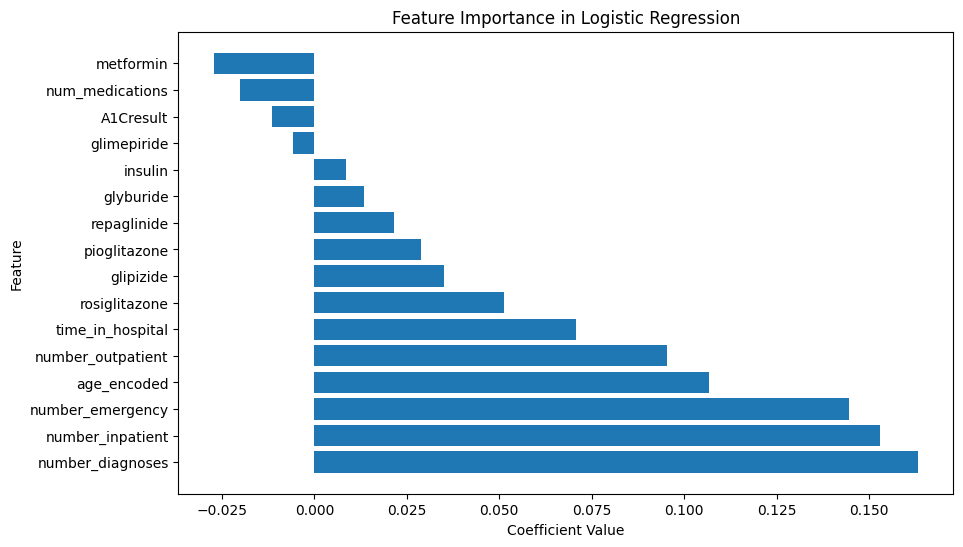

In [21]:
import matplotlib.pyplot as plt
#Visualize the Feature Importance: For better interpretation
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Coefficient'])
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Importance in Logistic Regression')
plt.show()

The maximum accuracy able to achieve with the logistic LogisticRegression model is .62